# WSTĘP
Projekt na przedmiot Rachunek prawdopodobieństwa i statystyka 2024/2025.
Obejmuje on analizę statystyczną ceny mieszkań i ich danych w wybranych miastach w Polsce.
Źródło opracowanych danych *https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland/data*

# Wczytanie danych
Importuję potrzebne mi biblioteki.

In [1]:
import pandas as pd
import sqlite3
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

Zgrywamy teraz dane z plików .csv do bazy SQLite i je czyścimy.

In [2]:
data_directory = './data'
conn = sqlite3.connect('apartments.db')

# Wczytanie plików ze sprzedażą mieszkań
sale_files = glob.glob(os.path.join(data_directory, 'apartments_pl_*.csv'))

# Pobranie wszystkich tabel w bazie danych
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Usunięcie każdej tabeli
for table in tables:
    table_name = table[0]
    cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
    print(f"Tabela {table_name} została usunięta.")

# Wczytanie nowych danych
for file in sale_files:
    # Wczytanie danych
    df = pd.read_csv(file)
    
    # CZYSZCZENIE DANYCH
    # Puste miejsca w bazie wypełniamy gdzie ma to sens
    df['type'] = df['type'].fillna('unknown')
    df['buildingMaterial'] = df['buildingMaterial'].fillna('other')
    df['hasElevator'] = df['hasElevator'].fillna('no')

    # Zamieniamy dane z 'no' i 'yes' na 0 i 1
    columns_to_change = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
    maping = {'yes': 1, 'no': 0}
    df[columns_to_change] = df[columns_to_change].map(lambda x: maping.get(x, x))


    # Usuwanie niepotrzebnych kolumn / kolumn z dużą ilością nulli
    rare_columns = ['clinicDistance','kindergartenDistance','condition','longitude', 'latitude',
                    'restaurantDistance','pharmacyDistance','postOfficeDistance','ownership']
    df = df.drop(columns=rare_columns)
    
    # Dodanie kolumny z datą (z nazwy pliku)
    filename = os.path.basename(file)
    date = filename.split('_')[2:4]  # Wyciąga YYYY_MM z nazwy
    df['date'] = f"{date[0]}-{date[1].split('.')[0]}"
        
    # Zapis do bazy
    df.to_sql('apartments_sale', conn, if_exists='append', index=False)

Tabela apartments_sale została usunięta.


Tworzymy jeszcze indeksy i zamykamy connection.

In [3]:
cursor = conn.cursor()
    

cursor.execute(f"""
    CREATE INDEX IF NOT EXISTS idx_apartments_sale_city 
    ON apartments_sale(city)
""")
cursor.execute(f"""
    CREATE INDEX IF NOT EXISTS idx_apartments_sale_date 
    ON apartments_sale(date)
""")

conn.commit()
conn.close()

# Analiza eksploracyjna
Na początek dodam DataFrame, na którym będziemy pracować.

In [4]:
conn = sqlite3.connect('apartments.db')
query = "SELECT * FROM apartments_sale"
data_frame = pd.read_sql_query(query, conn)

### Analiza statystyki opisowej dla wybranych kolumny
W tej części kodu wybrałem sześć kolumn, które uznałem za istotne do dalszej analizy:
- `price` (cena)
- `squareMeters` (powierzchnia mieszkania)
- `rooms` (liczba pokoi)
- `buildYear` (rok budowy)
- `floor` (piętro)
- `floorCount` (liczba pięter w budynku)

Następnie wykonałem analizę statystyczną dla tych kolumn, używając funkcji `describe()`, która generuje miary położenia (takie jak średnia), miary rozproszenia (takie jak odchylenie standardowe) oraz inne istotne informacje, np. minimum, maksimum, mediana.

Na koniec, dla czytelności, zaokrąglam wyniki do dwóch miejsc po przecinku.

In [5]:
important_columns = ['price', 'squareMeters', 'rooms', 'buildYear', 'floor', 'floorCount']
stats = data_frame[important_columns].describe().round(2)
print(stats)

            price  squareMeters      rooms  buildYear      floor  floorCount
count   195568.00     195568.00  195568.00  163352.00  160974.00   193185.00
mean    784183.30         58.70       2.68    1985.98       3.33        5.31
std     409709.23         21.41       0.92      33.81       2.53        3.31
min     150000.00         25.00       1.00    1850.00       1.00        1.00
25%     520000.00         44.00       2.00    1967.00       2.00        3.00
50%     699000.00         54.60       3.00    1994.00       3.00        4.00
75%     930000.00         68.55       3.00    2016.00       4.00        6.00
max    3250000.00        150.00       6.00    2024.00      29.00       29.00


Widać tutaj że odchylenie standardowe danych jest dość spore, co oznacza duże zróżnicowanie danych w kolumnach `price`, `squareMeters`, `buildYear`, `floor`, `floorCount`.

### Wizualizacja ilości mieszkań w bazie danych w poszczególnych miastach

W tym kodzie utworzyłem wykres słupkowy przedstawiający liczbę mieszkań w poszczególnych miastach w bazie danych, aby zobaczyć jaką mamy wielkość próbki.

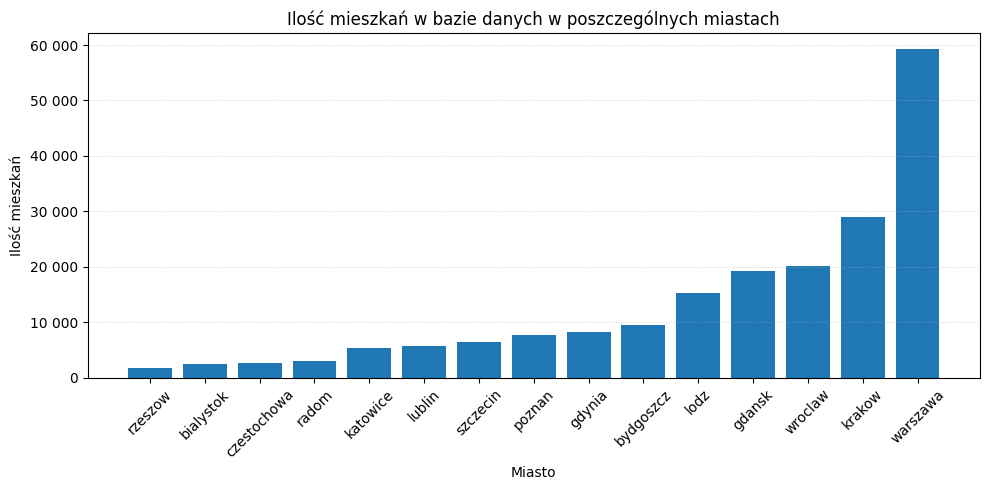

In [6]:
plt.figure(figsize = (10,5))
df = data_frame.groupby(['city'])['id'].count().reset_index()
df = df.sort_values(by = 'id')

plt.xlabel('Miasto')
plt.ylabel('Ilość mieszkań')
plt.title('Ilość mieszkań w bazie danych w poszczególnych miastach')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.bar(df['city'], df['id'])
    
plt.grid(True, axis='y', linestyle = ':', alpha=0.5)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Wizualizacja ilości mieszkań w bazie danych w poszczególnych miesiącach

W tym kodzie utworzyłem wykres słupkowy przedstawiający liczbę mieszkań w poszczególnych miesiącach w bazie danych, aby zobaczyć jaką mamy wielkość próbki.

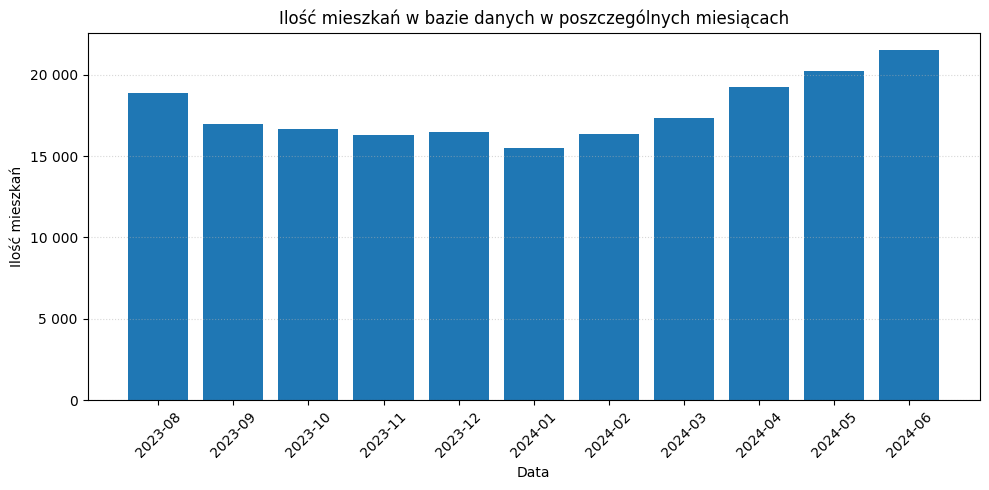

In [7]:
plt.figure(figsize = (10,5))
df = data_frame.groupby(['date'])['price'].count().reset_index()
df = df.sort_values(by = 'date')

plt.xlabel('Data')
plt.ylabel('Ilość mieszkań')
plt.title('Ilość mieszkań w bazie danych w poszczególnych miesiącach')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.bar(df['date'], df['price'])
    
plt.grid(True, axis='y', linestyle = ':', alpha=0.5)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Wizualizacja punktowa mieszkań
Ten kod generuje wykres rozkładu punktowego (scatter plot) dla danych dotyczących mieszkań. Oś X reprezentuje powierzchnię mieszkań w metrach kwadratowych (`squareMeters`), a oś Y przedstawia cenę mieszkań (`price`).

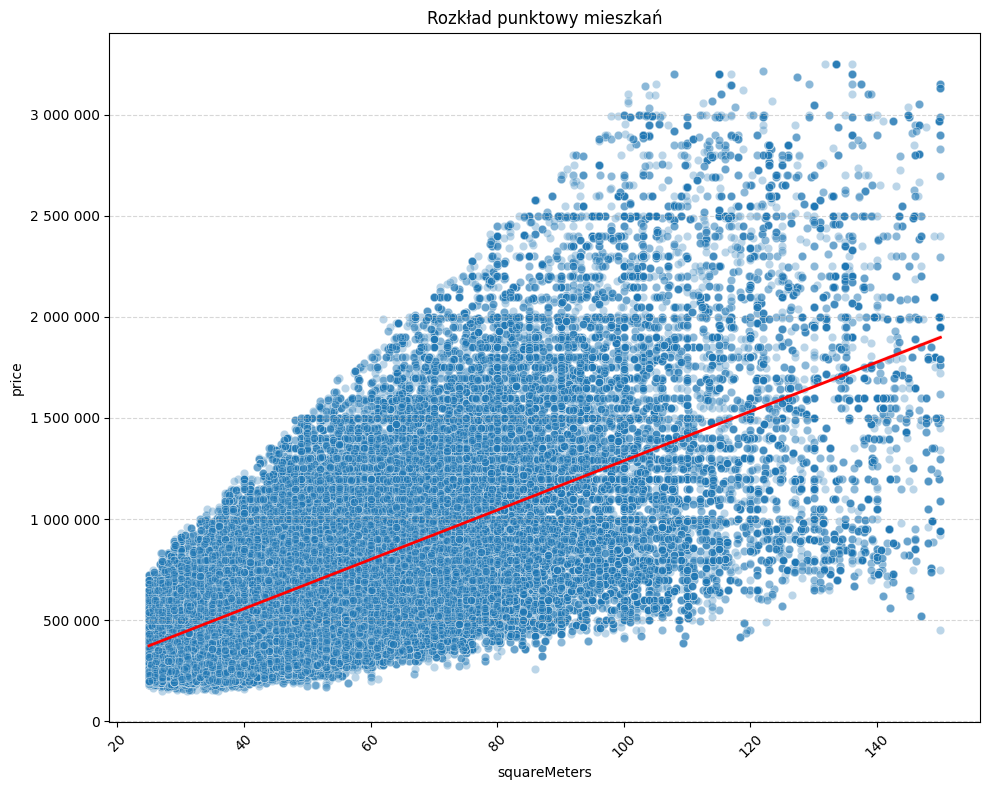

In [8]:
plt.figure(figsize = (10,8))
sns.scatterplot(data=data_frame, x='squareMeters', y='price', alpha=0.3)
sns.regplot(data=data_frame, x='squareMeters', y='price', scatter=False, color='red', line_kws={"lw": 2})

plt.title('Rozkład punktowy mieszkań')
    
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)
 
plt.tight_layout()
plt.show()

### Wykres wielkości mieszkań
Ten kod rysuje histogram przedstawiający rozkład powierzchni mieszkań (squareMeters) w całej bazie danych. Histogram pomoże zobaczyć, jakie powierzchnie mieszkań występują najczęściej.

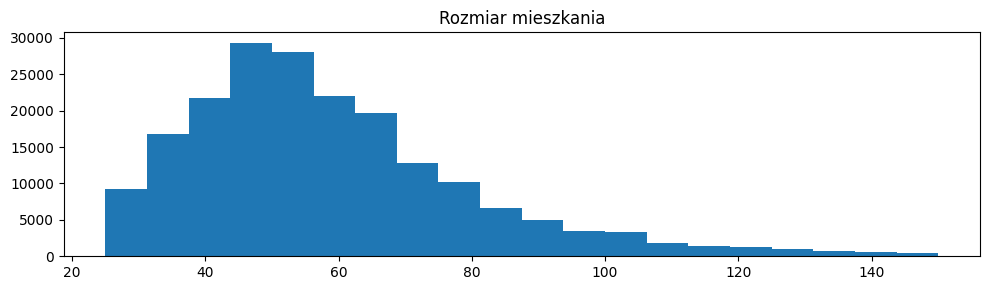

In [9]:
plt.figure(figsize=(10,3))
plt.title("Rozmiar mieszkania")
plt.hist(data_frame['squareMeters'], bins=20)
    
plt.tight_layout()
plt.show()

### Wizualizacja ceny mieszkań w poszczególnych miastach

W tym kodzie generujemy wykres pudełkowy (boxplot), który pokazuje rozkład cen mieszkań w różnych miastach. Wykres ten dostarcza istotnych informacji na temat rozkładu cen mieszkań w różnych miastach, pozwalając na porównanie, w których miastach ceny są wyższe, a gdzie niższe, oraz gdzie znajdują się ekstremalne wartości (np. bardzo drogie lub tanie mieszkania).

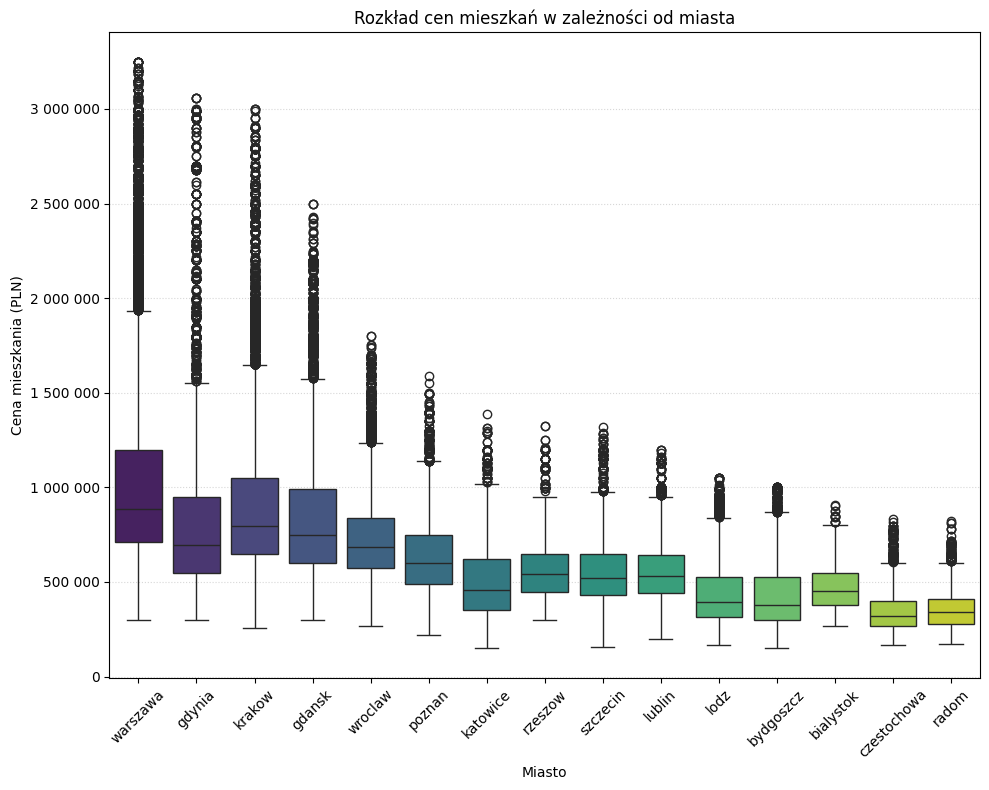

In [10]:
df = data_frame.sort_values(by = 'price', ascending = False)
plt.figure(figsize=(10, 8))
sns.boxplot(x = 'city', y='price', data = df, hue = 'city', palette = 'viridis', dodge = False)

plt.xlabel('Miasto')
plt.ylabel('Cena mieszkania (PLN)')
plt.title('Rozkład cen mieszkań w zależności od miasta')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle = ':', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

W tym kodzie również generujemy wykres pudełkowy (boxplot), który tym razem pokazuje rozkład cen metra kwadratowego w różnych miastach.

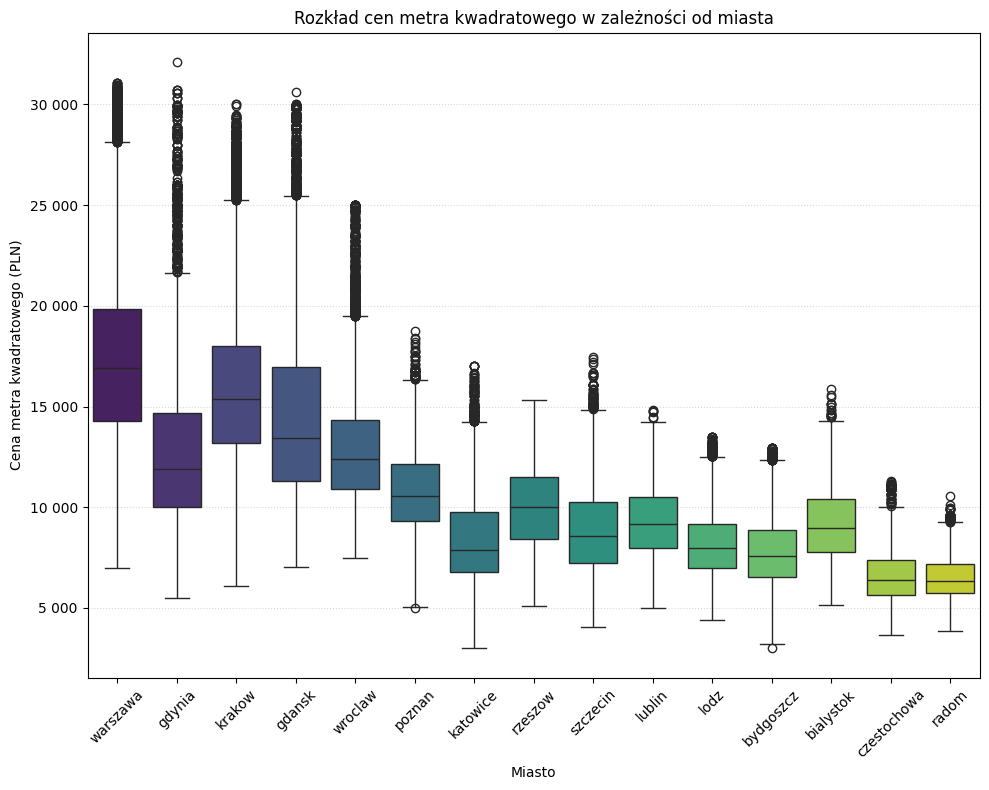

In [11]:
df['price_per_sqm'] = df['price'] / df['squareMeters']
plt.figure(figsize=(10, 8))
sns.boxplot(x = 'city', y='price_per_sqm', data = df, hue = 'city', palette = 'viridis', dodge = False)

plt.xlabel('Miasto')
plt.ylabel('Cena metra kwadratowego (PLN)')
plt.title('Rozkład cen metra kwadratowego w zależności od miasta')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle = ':', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Kolejny wyres analizuje, ile średnich pensji (na rękę) potrzeba w różnych polskich miastach, aby kupić 1 metr kwadratowy mieszkania. Porównuje to z dwoma rodzajami wynagrodzenia:

In [12]:
salary_map = {
    'warszawa': 7178,
    'krakow': 7591,
    'gdansk': 7284,
    'wroclaw': 6509,
    'poznan': 6186,
    'szczecin': 6040,
    'katowice': 6429,
    'bialystok': 4854,
    'rzeszow': 5979,
    'lublin': 5455,
    'lodz': 5567,
    'bydgoszcz': 5476
}
it_salary_map = {
    'warszawa': 9887,
    'krakow': 10009,
    'gdansk': 8486,
    'gdynia': 8486,
    'wroclaw': 9371,
    'poznan': 8591,
    'szczecin': 8206,
    'czestochowa': 7977,
    'katowice': 8293,
    'bialystok': 4854,
    'rzeszow': 5793,
    'lublin': 6976,
    'lodz': 8997,
    'bydgoszcz': 8852,
}

Średnie wynagrodzenie w danym mieście. (źródło: *https://300gospodarka.pl/news/oto-mapa-polskich-plac-mamy-nowy-ranking-zarobkow-w-najwiekszych-miastach-grafika*, *https://zarobki.pracuj.pl/kalkulator-wynagrodzen/*)

Średnie wynagrodzenie w branży IT w tym samym mieście. (źródło: *https://bulldogjob.pl/it-report/2024/zarobki-w-it#general-zarobki-a-miasto-srednia_0*)

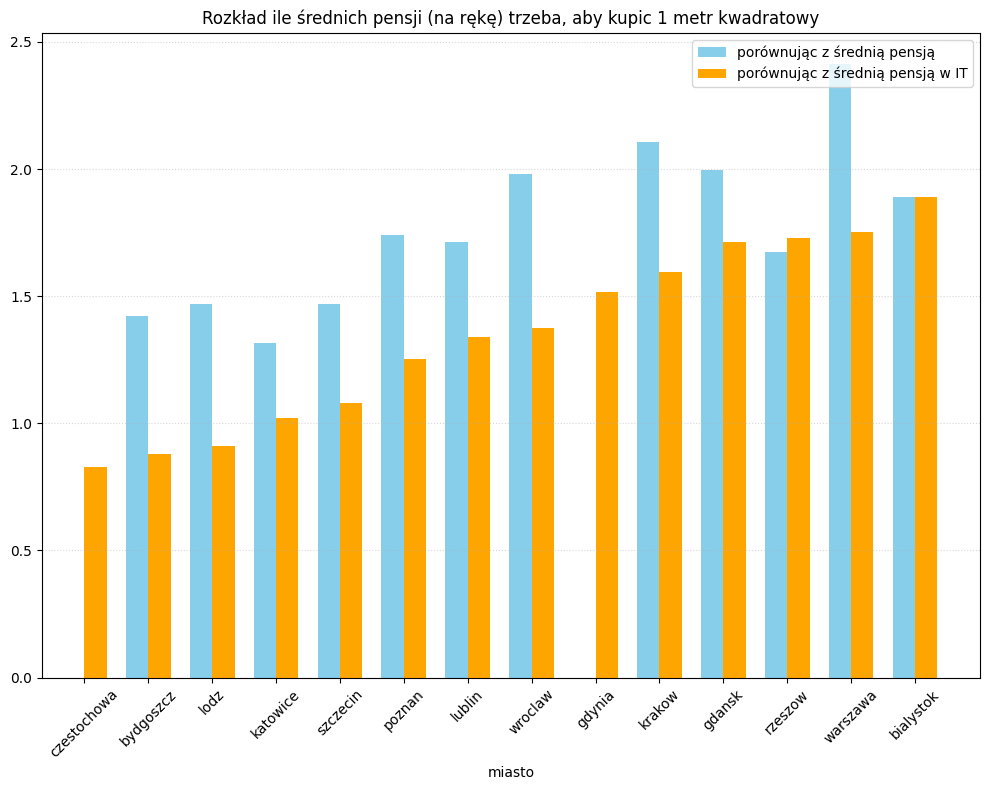

In [13]:
df = df.groupby(['city'])['price_per_sqm'].mean().reset_index()
df['avg_salary'] = df['city'].map(salary_map)
df['avg_it_salary'] = df['city'].map(it_salary_map)
df['m2_per_salary'] = df['price_per_sqm'] / df['avg_salary']
df['m2_per_it_salary'] = df['price_per_sqm'] / df['avg_it_salary']

df = df.sort_values(by = 'm2_per_it_salary')
df = df.dropna(subset = 'm2_per_it_salary')

plt.figure(figsize=(10, 8))
    
bar_width = 0.35
index = np.arange(len(df))

plt.bar(index, df['m2_per_salary'], bar_width, label='porównując z średnią pensją', color='skyblue')
plt.bar(index + bar_width, df['m2_per_it_salary'], bar_width, label='porównując z średnią pensją w IT', color='orange')

plt.xlabel('miasto')
plt.title('Rozkład ile średnich pensji (na rękę) trzeba, aby kupic 1 metr kwadratowy')

plt.grid(True, axis='y', linestyle = ':', alpha=0.5)
plt.xticks(index + bar_width / 2, df['city'], rotation = 45)

plt.tight_layout()
plt.legend()
plt.show()

Można z tego wykresu wyciągnąć, że pracując w IT i planując kupić mieszkanie w mieście pracy, najbardziej opłaca się praca w Częstochowie, a dla ludzi spoza IT zdecydowanie najciężej będzie zakupić mieszkanie w Warszawie.

### Analiza Rozkładów: Materiał Budowy i Typ Budynku, a Data Budowy
Ta funkcja rysuje histogram przedstawiający rozkład lat budowy mieszkań w zależności od materiału budowlanego.

Można się spodziewać, że mieszkania z płyt betonowych będą mieć większą liczbę budowy w latach PRL-u, podczas gdy cegła będzie dominować w starych kamienicach i nowszych apartamentowcach.

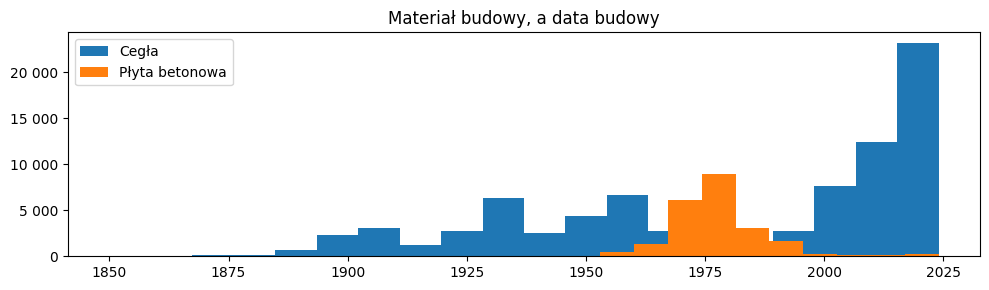

In [14]:
plt.figure(figsize=(10,3))
plt.title("Materiał budowy, a data budowy")
plt.hist(data_frame[data_frame['buildingMaterial'] == 'brick']['buildYear'], bins=20, label="Cegła")
plt.hist(data_frame[data_frame['buildingMaterial'] == 'concreteSlab']['buildYear'], bins=20, label="Płyta betonowa")

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.legend()
plt.tight_layout()
plt.show()

Kolejna funkcja generuje histogramy przedstawiające rozkład lat budowy dla różnych typów budynków: bloków mieszkalnych, budynków mieszkalnych typu apartamentowego oraz kamienic.

Możemy się spodziewać, że bloki mieszkalne były budowane w szczególności w latach PRL-u, kamienice nawet w czasach jeszcze przedwojnennych, a apartamentowce są ostatnio coraz popularniejszą opcją.

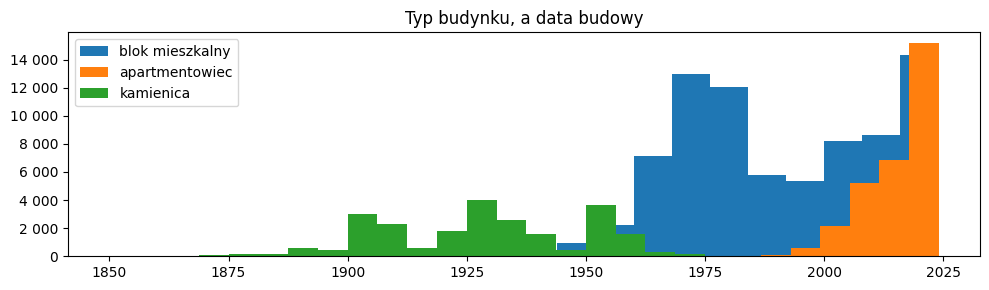

In [15]:
plt.figure(figsize=(10,3))
plt.title("Typ budynku, a data budowy")
plt.hist(data_frame[data_frame['type'] == 'blockOfFlats']['buildYear'], bins=20, label="blok mieszkalny")
plt.hist(data_frame[data_frame['type'] == 'apartmentBuilding']['buildYear'], bins=20, label="apartmentowiec")
plt.hist(data_frame[data_frame['type'] == 'tenement']['buildYear'], bins=20, label="kamienica")
    
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
    
plt.legend()
plt.tight_layout()
plt.show()

### Analiza Rozkładu Pięter w Budynkach
Funkcja ta analizuje zależność między piętrem mieszkania a liczbą pięter w budynku, przedstawiając to za pomocą wykresu punktowego, gdzie kolor punktów reprezentuje liczbę mieszkań na danym piętrze.

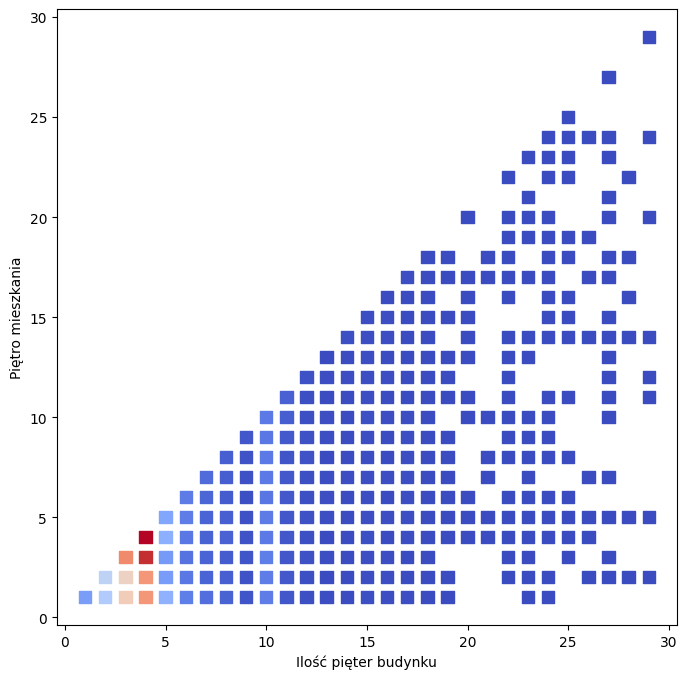

In [16]:
plt.figure(figsize = (8,8))

df = data_frame.groupby(['floor', 'floorCount'])['price'].count().reset_index()
df = df.sort_values(by = 'floor', ascending = True)

plt.xlabel('Ilość pięter budynku')
plt.ylabel('Piętro mieszkania')
plt.scatter(df['floorCount'], df['floor'], c=df['price'], cmap='coolwarm', s=80, marker='s')
plt.show()

### Analiza cech mieszkań
Porównanie mieszkań z wybranymi cechami w różnych miastach oraz ich wpływu na ceny mieszkań.

Następujący kod generuje wykresy słupkowe przedstawiające procentowy udział mieszkań z wybranymi cechami (np. balkon, miejsce parkingowe) w różnych miastach.

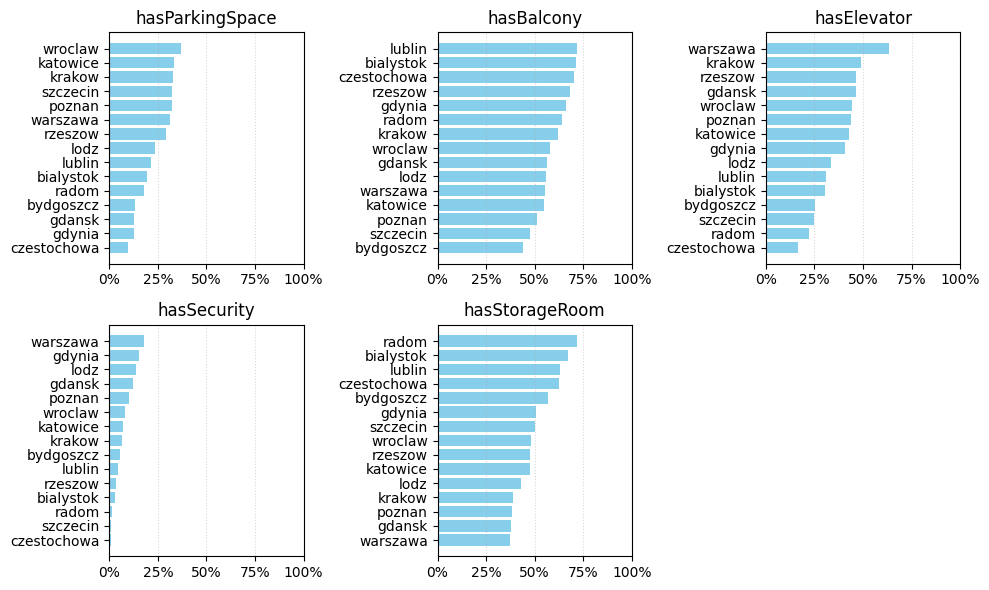

In [17]:
def get_feature_stats(feature):
    featureStats = pd.DataFrame(data_frame[data_frame[feature] == 1].groupby(['city'])[feature].count()).reset_index()
    featureStats['all'] = pd.DataFrame(data_frame.groupby(['city'])['price'].count()).reset_index().rename({'price': 'all'}, axis=1)['all']
    featureStats['percentage'] = featureStats[feature] / featureStats['all']
    return featureStats.sort_values(['percentage'], ascending=True)

features = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']
fig = plt.figure(figsize = (10, 6))
i = 0
for feature in features:
    i += 1
    subplot = fig.add_subplot(2,3,i)
    stats = get_feature_stats(feature)
    subplot.set_title(feature)
    subplot.barh(stats['city'], stats['percentage'], color = 'skyblue')
    subplot.set_xlim(0,1)
    subplot.xaxis.set_major_formatter(tick.PercentFormatter(1))
    subplot.grid(True, axis = 'x', linestyle = ':', alpha = 0.5)

plt.subplots_adjust(wspace = 0.8)
plt.tight_layout()
plt.show()

Kolejny kod generuje wykresy porównujące średnią i medianę cen mieszkań w zależności od tego, czy mieszkanie ma daną cechę (np. balkon, miejsce parkingowe).

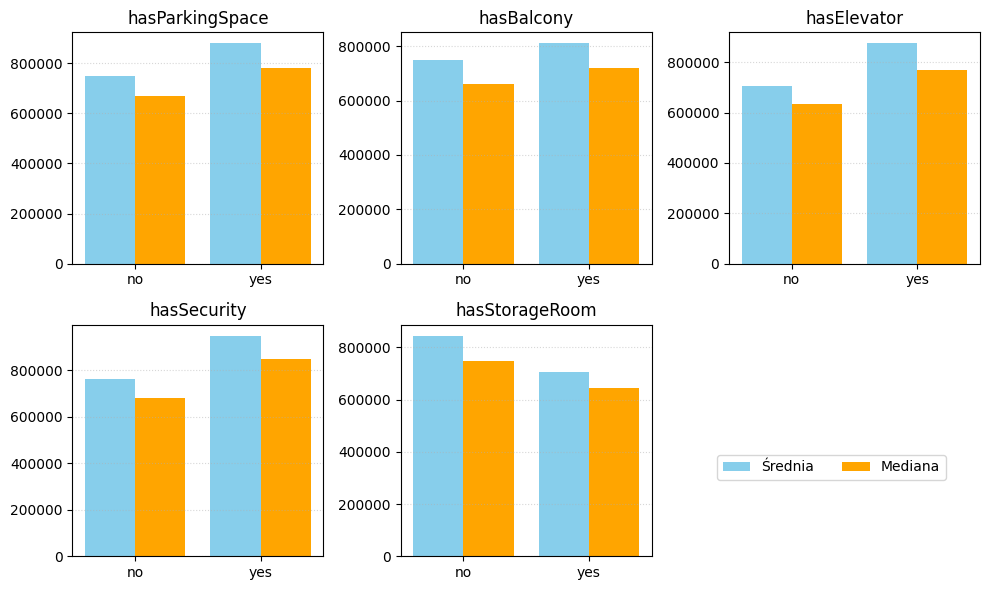

In [18]:
features = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']
fig = plt.figure(figsize = (10, 6))
i = 0
handles = []
labels = []

for feature in features:
    i += 1
    subplot = fig.add_subplot(2,3,i)
    stats = data_frame.groupby(feature)['price'].agg(
        mean_price = 'mean',
        median_price = 'median'
    ).reset_index()

    bar_width = 0.4
    x = stats[feature]
    mean_bar = subplot.bar(x - bar_width / 2, stats['mean_price'], bar_width,
                 label = 'Średnia', color = 'skyblue')
    median_bar = subplot.bar(x + bar_width / 2, stats['median_price'], bar_width,
                 label = 'Mediana', color = 'orange')
    
    if i == 1:
        handles.extend([mean_bar, median_bar])
        labels.extend(['Średnia', 'Mediana'])

    subplot.set_title(feature)
    subplot.set_xlim(-0.5, 1.5)
    subplot.set_xticks([0, 1])
    subplot.set_xticklabels(['no', 'yes'])
    subplot.grid(True, axis = 'y', linestyle = ':', alpha = 0.5)
    
plt.subplots_adjust(wspace = 0.8)
plt.tight_layout()
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (2.2, 0.3), ncol = 2)
plt.show()

### Analiza zmian cen mieszkań w czasie
Kod wizualizuje zmiany średniej i mediany cen mieszkań w czasie.

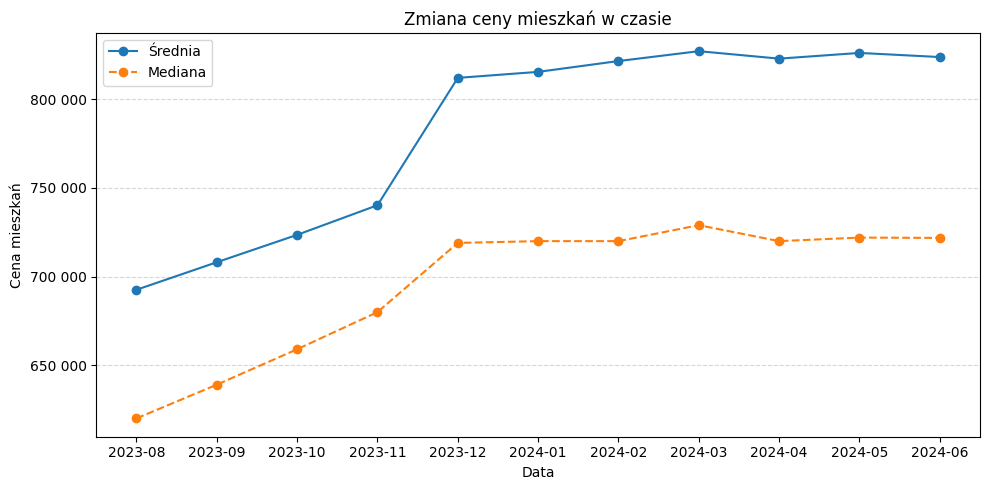

In [19]:
df_mean = data_frame.groupby('date')['price'].mean().reset_index()
df_median = data_frame.groupby('date')['price'].median().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_mean['date'], df_mean['price'], marker='o', label='Średnia')
plt.plot(df_median['date'], df_median['price'], marker='o', label='Mediana', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Cena mieszkań')
plt.title('Zmiana ceny mieszkań w czasie')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

### Analiza wpływu odległości punktów użyteczności publicznej na cenę mieszkania
Niżej podany kod przestawia wykres zależności odległości od najbliższej szkoły.

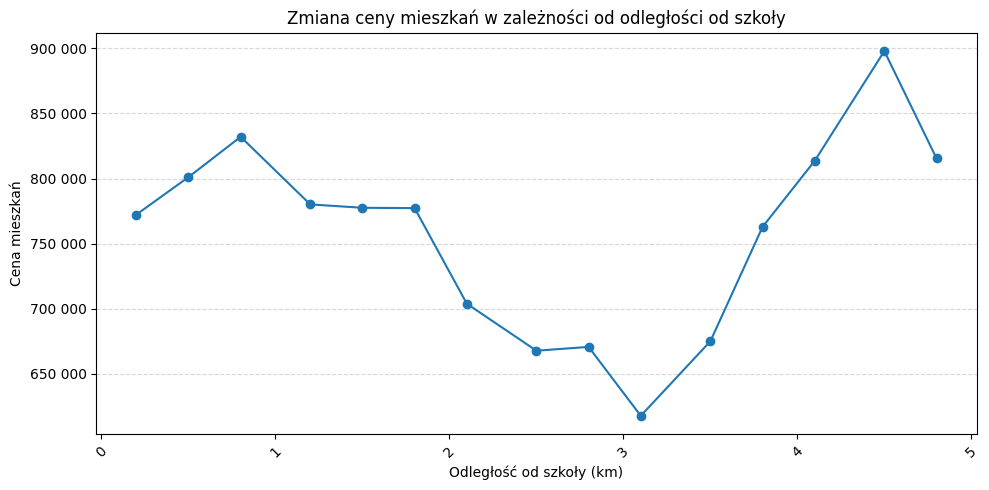

In [20]:
df = data_frame
df['distance_group'] = pd.cut(df['schoolDistance'], bins = 15)
df['mid_point'] = df['distance_group'].apply(lambda x: round(x.mid, 1))
df_school = df.groupby('mid_point', observed=True)['price'].mean().reset_index()

plt.figure(figsize = (10,5))
plt.plot(df_school['mid_point'], df_school['price'], marker = 'o')
   
plt.xlabel('Odległość od szkoły (km)')
plt.ylabel('Cena mieszkań')
plt.title('Zmiana ceny mieszkań w zależności od odległości od szkoły')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Mimo że wydawałoby się to ważne, żeby szkoła była blisko, to nie widać zależności między odległością od szkoły a ceną mieszkania.

Następny kod przedstawia zależność między odległością od szkoły wyższej, a ceną mieszkania.

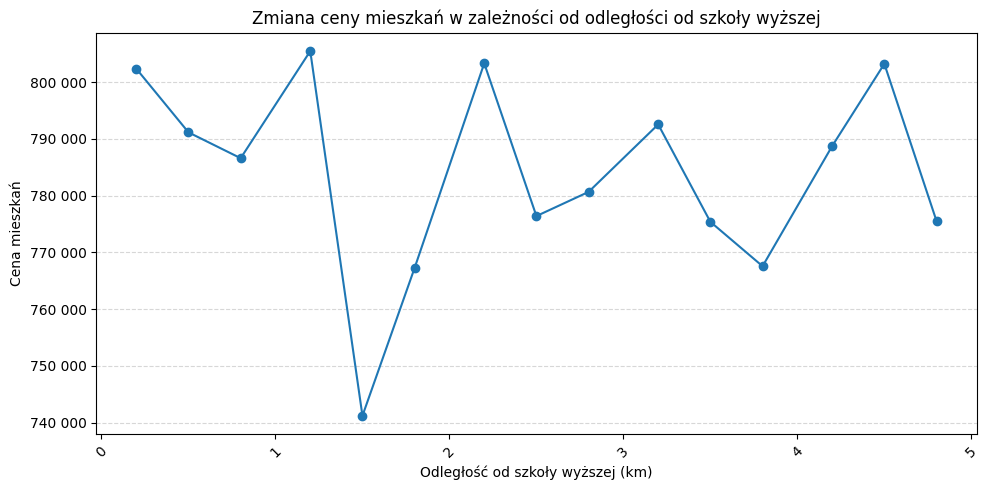

In [21]:
df['distance_group'] = pd.cut(df['collegeDistance'], bins = 15)
df['mid_point'] = df['distance_group'].apply(lambda x: round(x.mid, 1))
df_college = df.groupby('mid_point', observed=True)['price'].mean().reset_index()

plt.figure(figsize = (10,5))
plt.plot(df_college['mid_point'], df_college['price'], marker = 'o')
    
plt.xlabel('Odległość od szkoły wyższej (km)')
plt.ylabel('Cena mieszkań')
plt.title('Zmiana ceny mieszkań w zależności od odległości od szkoły wyższej')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Następujący kod przedstawia wykres zależności ilości punktów użyteczności publicznej (POI - points of interest) - np. szkół, sklepów - w odległości 500m od mieszkania, a jego odległości od centrum miasta, w którym sie znajduje.

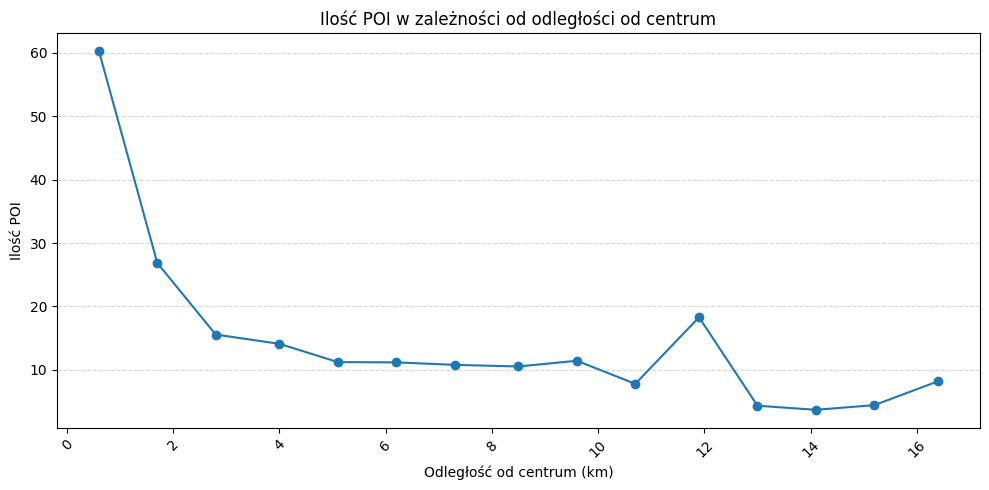

In [22]:
df['distance_group'] = pd.cut(df['centreDistance'], bins = 15)
df['mid_point'] = df['distance_group'].apply(lambda x: round(x.mid, 1))
df_poi = df.groupby('mid_point', observed=True)['poiCount'].mean().reset_index()

plt.figure(figsize = (10,5))
plt.plot(df_poi['mid_point'], df_poi['poiCount'], marker = 'o')
    
plt.xlabel('Odległość od centrum (km)')
plt.ylabel('Ilość POI')
plt.title('Ilość POI w zależności od odległości od centrum')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)
 
plt.tight_layout()
plt.show()

Można zauważyć, że w centrum jest średnio więcej POI, niż na obrzeżach, co jest dość oczywiste.

### Analiza wpływu odległości od centrum na cenę mieszkania
Następny kod generuje wykres zależności między odległością od centrum, a ceną mieszkania.

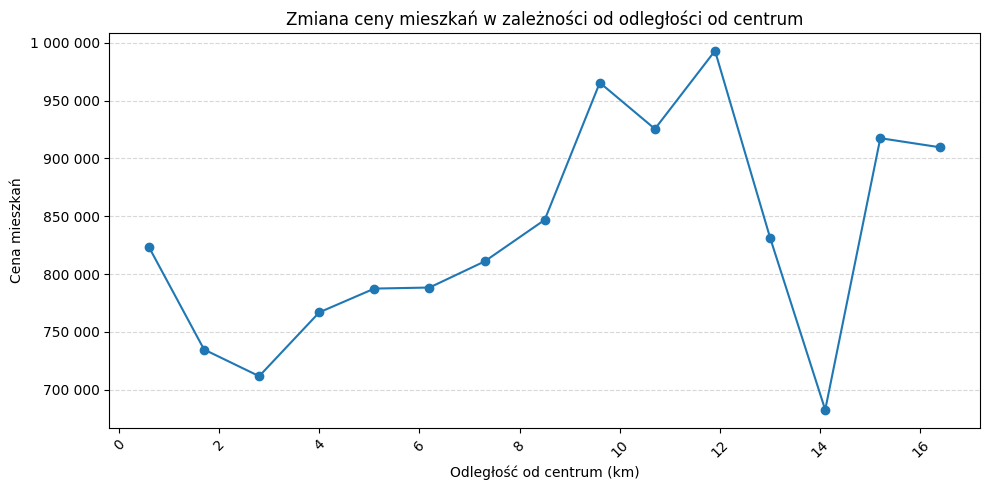

In [23]:
df_centre = df.groupby('mid_point', observed=True)['price'].mean().reset_index()

plt.figure(figsize = (10,5))
plt.plot(df_centre['mid_point'], df_centre['price'], marker = 'o')
    
plt.xlabel('Odległość od centrum (km)')
plt.ylabel('Cena mieszkań')
plt.title('Zmiana ceny mieszkań w zależności od odległości od centrum')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Wykres nie wydaje sie wykazywać żadnej zależności między ceną mieszkania, a odległością od centrum miasta.

Kolejny kod będzie porównywał tym razem cenę metra kwadratowego mieszkania.

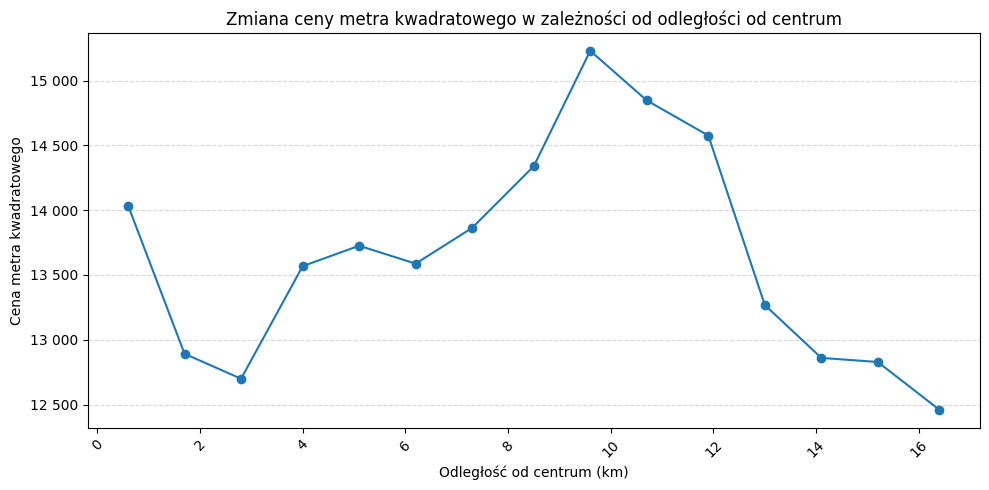

In [24]:
df['price_per_m2'] = df['price']/df['squareMeters']
df_centre_m2 = df.groupby('mid_point', observed=True)['price_per_m2'].mean().reset_index()

plt.figure(figsize = (10,5))
plt.plot(df_centre_m2['mid_point'], df_centre_m2['price_per_m2'], marker = 'o')
    
plt.xlabel('Odległość od centrum (km)')
plt.ylabel('Cena metra kwadratowego')
plt.title('Zmiana ceny metra kwadratowego w zależności od odległości od centrum')

axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Wykres również nie wykazuje żadnej zależności, ale różni się znacząco od poprzedniego dla bardziej oddalonych mieszkań. Sprawdzę czy jest to jakoś ze sobą zależne na kolejnym wykresie generowanym przez następujący kod.

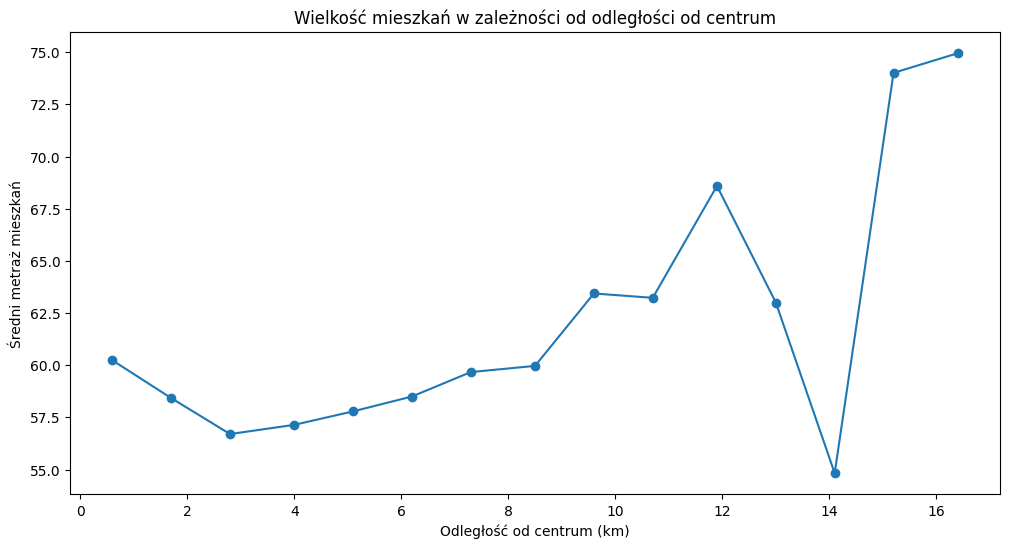

In [25]:
df_size = df.groupby('mid_point', observed=True)['squareMeters'].mean().reset_index()

plt.figure(figsize = (12,6))
plt.plot(df_size['mid_point'], df_size['squareMeters'], marker = 'o')
    
plt.xlabel('Odległość od centrum (km)')
plt.ylabel('Średni metraż mieszkań')
plt.title('Wielkość mieszkań w zależności od odległości od centrum')

plt.show()

Pomijając odstający punkt dla 14 km, możemy zauważyć, że w dalszej odległości od centrum (na przedmieściach) mieszkania są średnio większe od tych w centrum. Jest to zgodne z obserwacją, że miasta rozbudowują się na zewnątrz, a deweloperzy mają większą przestrzeń do zagospodarowania w obrębie przedmieść, co sprzyja budowie większych nieruchomości.

## Korelacja między danymi

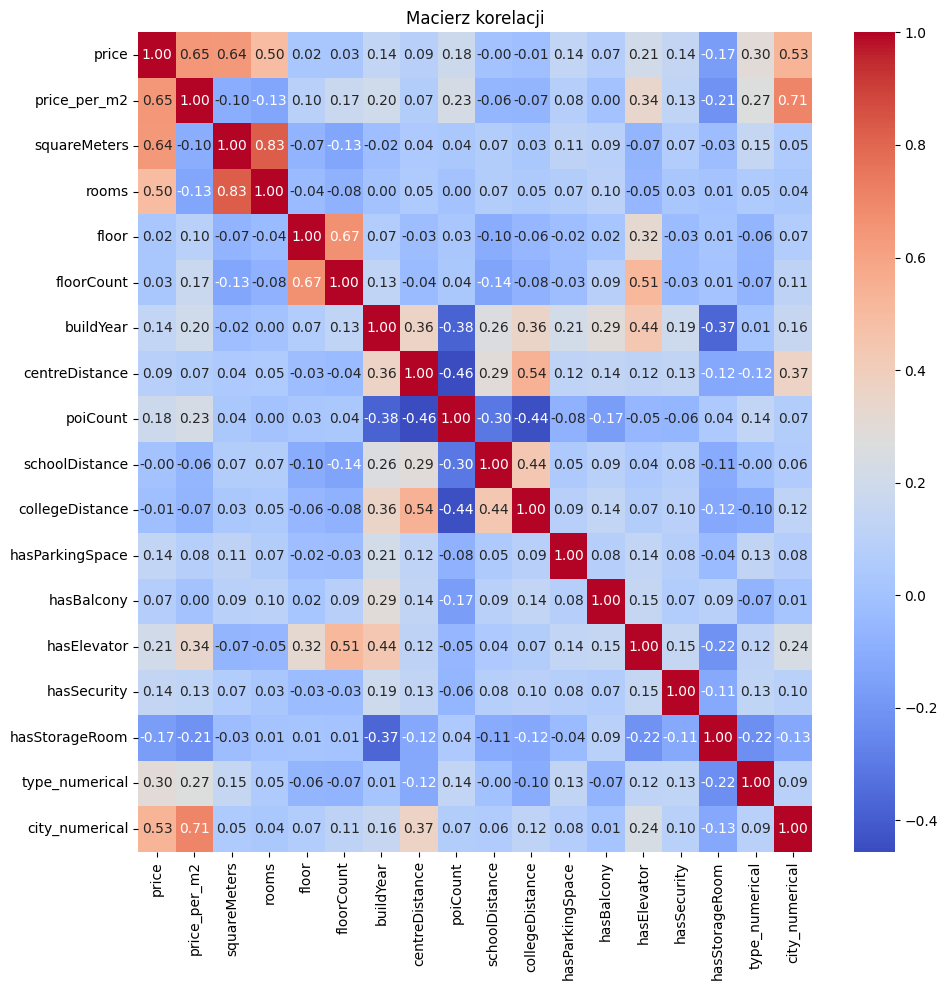

In [26]:
type_price_avg = df.groupby('type')['price'].mean()
type_sorted = type_price_avg.sort_values(ascending=True).index
type_mapping = {type_: idx for idx, type_ in enumerate(type_sorted)}
df['type_numerical'] = df['type'].map(type_mapping)
    
city_price_avg = df.groupby('city')['price'].mean()
city_sorted = city_price_avg.sort_values(ascending=True).index
city_mapping = {city: idx for idx, city in enumerate(city_sorted)}
df['city_numerical'] = df['city'].map(city_mapping)

df['price_per_m2'] = df['price']/df['squareMeters']

numeric_cols = ['price','price_per_m2', 'squareMeters',  'rooms', 'floor', 'floorCount', 'buildYear',
                'centreDistance', 'poiCount', 'schoolDistance', 'collegeDistance',
                'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
                'hasStorageRoom', 'type_numerical', 'city_numerical']

correlation = df[numeric_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji')

plt.tight_layout()
plt.show()

**Wnioski**:

- Z powyższej macierzy korelacji wynika, że największy wpływ na cenę mieszkania ma jego metraż i ilość pokoi (co jest dość oczywiste), miasto, w którym się znajduje, oraz posiadanie windy.

- Zaskakujące może się wydawać, że cena nie zależy znacząco od odległości od centrum, szkół i uniwersytetów

- Inne ciekawe wnioski to takie, że nowo wybudowane mieszkania są średnio dalej od centrum, szkół oraz uniwersytetów. Mają za to średnio więcej balkonów i wind, a mniej magazynów.


# Przewidywanie wyniku
Za pomocą regresji wielorakiej możemy spróbować przewidzieć cenę mieszkania, korzystając z jego parametrów, takich jak powierzchnia, liczba pokoi, rok budowy, piętro czy inne wartości liczbowe opisujące nieruchomość.

Regresja wieloraka pozwala modelować zależność między zmienną zależną (w tym przypadku ceną mieszkania) a wieloma zmiennymi niezależnymi (np. powierzchnią czy liczbą pokoi). Celem jest zbudowanie modelu matematycznego, który najlepiej odwzoruje tę zależność, umożliwiając przewidywanie cen dla nowych, nieznanych obserwacji.

Na początku importujemy potrzebne biblioteki, a później wybieramy te liczbowe parametry mieszkania, które mogą mieć wpływ na cenę i usuwamy z nich wszelkie nulle.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

numeric_cols = ['squareMeters', 'floor', 'buildYear',
            'centreDistance', 'poiCount', 'schoolDistance', 'collegeDistance',
            'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
            'hasStorageRoom', 'type_numerical', 'city_numerical']

df = df.dropna(subset = numeric_cols)

Następnie dzielimy dane na treningowe i testowe. Robimy to, abyśmy mogli przetestować nasz model na nowych danych.

In [28]:
y = df['price']
X = df[numeric_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Budujemy później i oceniamy nasz model regresji przy użyciu danych treningowych i testowych.

In [29]:
reg = LinearRegression()
reg.fit(X_train, y_train)
score = reg.score(X_test, y_test)
print(score)

0.7257496683792191


Funkcja score oblicza współczynnik determinacji R^2, który mierzy, jak dobrze model wyjaśnia zmienność zmiennej zależnej na danych testowych.

Następny kod przedstawi wyniki naszych przewidywań na wykresie punktowym.

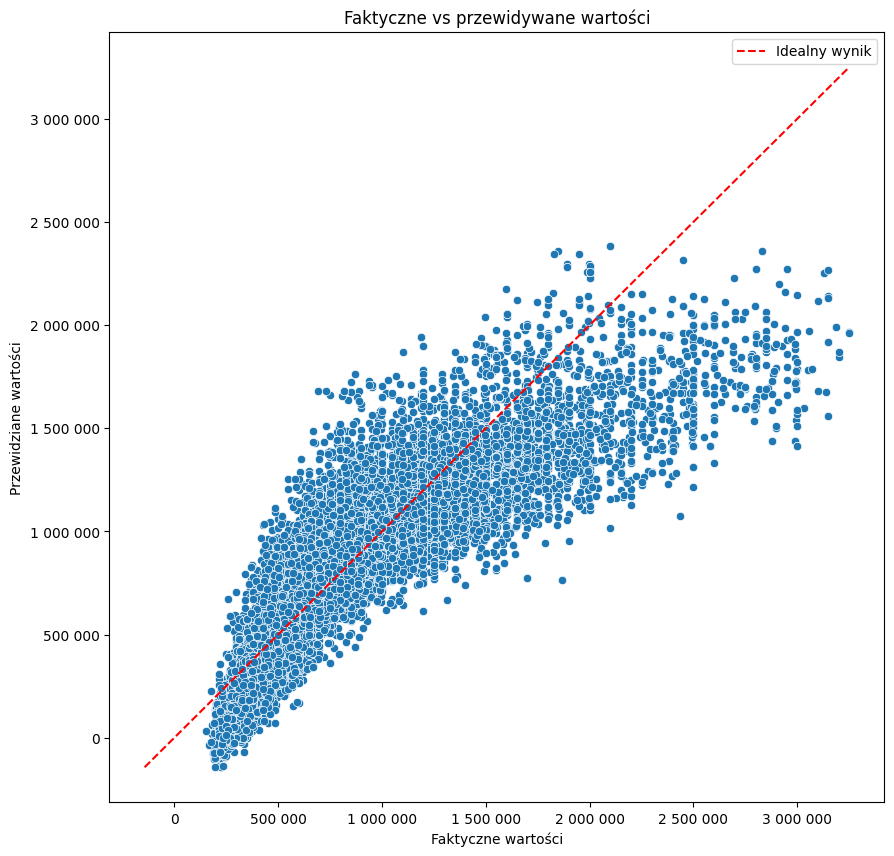

In [30]:
reg_y_pred = reg.predict(X_test)

min_val = min(min(y_test), min(reg_y_pred))
max_val = max(max(y_test), max(reg_y_pred))
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=reg_y_pred)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Idealny wynik')

axis = plt.gca()
axis.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.xlabel('Faktyczne wartości')
plt.ylabel('Przewidziane wartości')
plt.title('Faktyczne vs przewidywane wartości')
plt.legend()
plt.show()

Na kolejnym wykresie przedstawione będą różnice między idealnym wynikiem, a naszymi predykcjami.

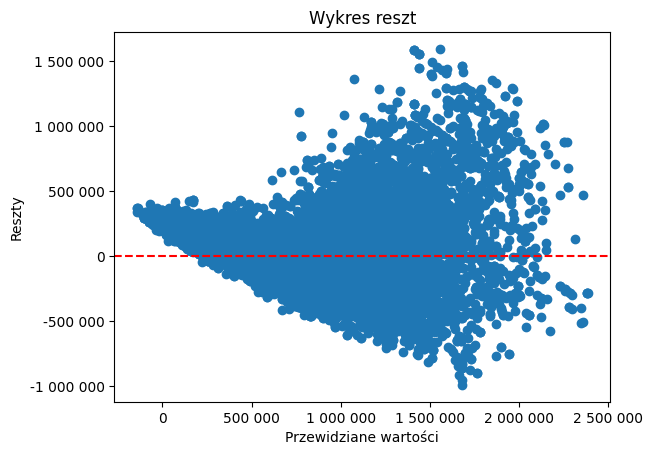

In [31]:
residuals = y_test - reg_y_pred
plt.scatter(reg_y_pred, residuals)

axis = plt.gca()
axis.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
axis.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.title('Wykres reszt')
plt.xlabel('Przewidziane wartości')
plt.ylabel('Reszty')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Przykładowe użycie modelu.

In [32]:
new_data = np.array([70, 15, 2024, 5, 10, 2, 3, 0, 1, 1, 0, 0, 2, 10])
new_data_df = pd.DataFrame([new_data], columns=X.columns)
prediction = reg.predict(new_data_df).round(2)
print(prediction)

[935944.14]


# Podsumowanie
W notebooku przeanalizowałem dane, przygotowałem je do analizy, zwizualizowałem kluczowe zależności i przetestowałem model predykcyjny. Uzyskane wyniki analziy dostarczają wartościowych informacji i stanowią punkt wyjścia do dalszych analiz.